In [1]:
# %load imports.py
import os
from collections import namedtuple
from io import StringIO
import re

import requests

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import jax
from jax.experimental.ode import odeint, vjp_odeint
import jax.numpy as np
from jax.random import PRNGKey
import numpy as onp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az

NUM_CHAINS = 1
numpyro.set_host_device_count(NUM_CHAINS)
numpyro.enable_x64()

plt.style.use('ggplot')


# Estimating the impact of non-pharmaceutical interventions on COVID-19 infection spread through mobility data

We aim at answering the question :

**How does is the implementation of different strategies affecting the rates of COVID-19 infection ?**

# Summary
Through the Covid-19 pandemic, many countries have adopted mobility restriction policies, such as lockdown. Major technology companies have released _mobility_ datasets, that describe the mobility change, relative to a baseline, across different categories of places or modes of transportation.

We observe that countries cluster based on the mobility data, revealing patterns and similarities between government measures across different countries. We build a model that predicts mobility change based on non-pharmaceutical interventions (NPIs).  
Additionally, we build a bayesian model, that leverages an epidemiological compartmental model, in order to estimate the real effective reproduction number $R_t$ through time as a function of mobility data.  

This opens the possibility to build an end-to-end pipeline from NPIs to $R_t$ and compartments, e.g. number of hospitalized, critical and deceased individuals, in order to generate _what-if_ scenarios, useful to evaluate governement policies both restrospectively and prospectively.


![process](covid_estimation.svg)

<!-- # Related work

Regarding Covid-19 specifically, [Flaxman, Mishra, Gansy, Bhatt et al.](https://www.imperial.ac.uk/mrc-global-infectious-disease-analysis/covid-19/report-13-europe-npi-impact/) develop a a semi-mechanistic Bayesian hierarchical model to estimate the impact of interventions on 11 European countries, which they later tweak to [estimate](https://www.imperial.ac.uk/mrc-global-infectious-disease-analysis/covid-19/report-20-italy/) the transmission intensity in Italy. [Bryant and Elofsson](https://www.medrxiv.org/content/10.1101/2020.04.13.20063644v2) enrich the original model with Google mobility datasets.

## Mobility
The release of mobility datasets provided by Google and Apple is, to our knowledge, a novelty caused by the severity of the Covid-19 pandemic. Hence, related works leveraging mobility data are mostly recent.

Prior work done on mobility data include an [evaluation](https://www.medrxiv.org/content/10.1101/2020.04.05.20054288v2) of the effect of a urban mobility index on the virus growth rate, [synthetic intervention](https://arxiv.org/abs/2005.00072) -->

# Datasets

In [2]:
# %load fetching.py
from io import StringIO
import re
import requests

# country codes
def fetch_isocodes():
    isocodes = pd.read_csv('../input/countries-iso-codes/wikipedia-iso-country-codes.csv')
    isocodes.columns = isocodes.columns.str.replace(' ', '_').str.lower()
    isocodes = isocodes.rename({"english_short_name_lower_case": 'country_name'}, axis=1)
    return isocodes

# ACAPS
def fetch_acaps(isocodes, url=None):
    filepath = '../input/acaps-covid19-government-measures/acaps_covid19_goverment_measures_dataset.xlsx'
#     if url is not None:
#         measures = pd.read_excel(url, sheet_name='Database')
#         measures.to_csv(filepath, index=False)
    
    measures = pd.read_excel(filepath, sheet_name='Database')
    measures.columns = measures.columns.str.lower()
    measures['date_implemented'] = pd.to_datetime(measures['date_implemented'])

    measures = measures.merge(isocodes, left_on='iso', right_on='alpha-3_code')
    return measures

# ECDC for names of lactions
def fetch_ecdc():
    ecdc = (pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
            .assign(date=lambda f: f['date'].pipe(pd.to_datetime))
           )
    
    return ecdc

# Apple mobility

def fetch_apple(location_code, url=None):
    filepath = '../input/apple-covid-mobility/applemobilitytrends.csv'
    if url is not None:
        response = requests.get(url)
        apple_mobility = (pd.read_csv(StringIO(response.content.decode())))
        apple_mobility.to_csv(filepath, index=False)

    apple_mobility = (pd.read_csv(filepath)
                      .drop('alternative_name', axis=1)
                      .set_index(['geo_type', 'region', 'transportation_type'])
                      .rename_axis("date", axis=1)
                      .stack()
                      .rename('change')
                      .reset_index('date')
                      .assign(date=lambda f: pd.to_datetime(f['date']))
                      .set_index('date', append=True)
                      )

    apple_mobility = (apple_mobility
                      .reset_index()
                      .replace({'UK': 'United Kingdom', 'Republic of Korea': 'South Korea', 'Macao': 'Macau'})  # Only missing is Macao
                      .merge(location_code, left_on='region', right_on='location', how='left')
                     .assign(change=lambda f: f['change'].div(100).sub(1)))

    apple_mobility = apple_mobility.loc[lambda f: f['iso_code'].notna()].set_index(['iso_code', 'date', 'transportation_type'])['change'].unstack()
    return apple_mobility

def fetch_google(isocodes, location_code):
    google_mobility = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv', parse_dates=['date'])

    def safe_match(pat, text):
        match = re.match(pat, text)
        return match.groups()[0] if match else text

    google_mobility.columns = google_mobility.columns.map(lambda col: safe_match("(.*)_percent", col))
    google_mobility = (google_mobility
                .merge(isocodes, left_on='country_region_code', right_on='alpha-2_code', how='left')
                .merge(location_code, left_on='alpha-3_code', right_on='iso_code', how='left'))

    google_mobility = google_mobility.loc[lambda f: f['sub_region_1'].isna()].set_index(['iso_code', 'date']).select_dtypes(float).div(100)
    return google_mobility

# oxford.columns[mask].str.extract(r'(..)_.*', expand=False)

def fetch_oxford():
    oxford = pd.read_csv('https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/OxCGRT_latest.csv')
    oxford.columns = oxford.columns.map(str.lower).str.replace(' ', '_')
    oxford['date'] = pd.to_datetime(oxford['date'], format='%Y%m%d')

    ordinal_columns = oxford.columns[oxford.columns.str.contains("^c._.*_.*")]
    geographic_columns = oxford.columns[oxford.columns.str.contains('^c._flag')]
    strip_measure_name = lambda name: name.split('_')[0]
    measures_ix = dict(zip(ordinal_columns.map(strip_measure_name), ordinal_columns.map(lambda s: '_'.join(s.split('_')[1:]))))

    oxford_long = (oxford
                   .set_index(['countrycode', 'date'])
                   [geographic_columns]
                   .rename(columns=strip_measure_name)
                   .rename_axis('category', axis=1)
                   .stack()
                   .to_frame('flag')
                   .join(oxford.set_index(['countrycode', 'date'])
                         [ordinal_columns]
                         .rename(columns=strip_measure_name)
                         .replace(0, np.nan)
                         .rename_axis('category', axis=1)
                         .stack()
                         .rename('measure'),
                         how='outer'
                        )
                  )

    oxford_long = (oxford_long
                   .rename_axis('variable', axis=1)
                   .stack()
                   .rename('value'))
    return oxford_long, measures_ix

## Measures dataset

We leverage the _Coronavirus Government Response Tracker_ dataset from Oxford Blavatnik School of Government.

We are interested in the _Closure and containment_ indicators, which are described in the following section. 
Note that when no measure is in place, the indicator is at zero.

### Measures description

C1 School closing  
Record closings of schools and universities
- 1: recommend closing
- 2: Require closing (only some levels or categories, eg just high school, or just public schools)
- 3: Require closing all levelsNo data 

C2 Workplace closing  
Record closings of workplaces
- 1: recommend closing (or work from home)
- 2: require closing (or work from home)for some sectors or categories of workers
- 3: require closing (or work from home) all-but-essential workplaces (eg grocery stores, doctors)

C3 Cancel public events  
Record cancelling public events
- 1: Recommend cancelling
- 2: Require cancelling

C4 Restrictions on gatherings  
Record the cut-off size for bans on private gatherings
- 1: Restrictions on very large gatherings (the limit is above 1000 people)
- 2: Restrictions on gatherings between 100-1000 people
- 3: Restrictions on gatherings between 10-100 people
- 4: Restrictions on gatherings of less than 10 people

C5 Close public transport  
Record closing of public transport
- 1: Recommend closing (or significantly reduce volume/route/means of transport available)
- 2: Require closing (or prohibit most citizens from using it)

C6 Stay at home requirements  
Record orders to “shelter-in-place” and otherwise confine to home
- 1: recommend not leaving house
- 2: require not leaving house with exceptions for daily exercise, grocery shopping, and ‘essential’ trips
- 3: Require not leaving house with minimal exceptions (e.g. allowed to leave only once every few days, or only one personcan leave at a time, etc.)

C7 Restrictions on internal movement  
Record restrictions on internal movement
- 1: Recommend closing(or significantly reduce volume/route/means of transport)
- 2: Require closing (or prohibit most people from using it)

C8 International travel controls  
Record restrictions on international travel
- 1: Screening
- 2: Quarantine arrivals from high-risk regions
- 3: Ban on high-risk region

todo: insérer ici des viz du dataset oxford

## Mobility datasets
We gathered data from Google and Apple, describing respectively 6 and 3 mobility categories.

Google
- _Retail and recreation_
    - restaurants, cafes, shopping centers, theme parks, museums, libraries, and movie theaters.
- _Grocery and pharmacy_
    - grocery markets, food warehouses, farmers markets, specialty food shops, drug stores, and pharmacies.
- _Parks_
    - national parks, public beaches, marinas, dog parks, plazas,and public gardens
- _Transit stations_
    - public transport hubs such as subway, bus, and train stations
- _Workplaces_
- _Residential_

_The baseline is the median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020._

Apple
- _Driving_
- _Walking_
- _Transit_

_relative volume of directions requests per country/region, sub-region or city compared to a baseline volume on 13 January 2020_

todo: insérer ici des viz de mobilité

# Relationship between measures and mobility

##### Data fetching

In [ ]:
isocodes = fetch_isocodes()
acaps = fetch_acaps(isocodes)
ecdc = fetch_ecdc()
location_code = ecdc.groupby(['location', 'iso_code']).first().iloc[:, 0].reset_index().iloc[:,:2]
apple = fetch_apple(location_code)
google = fetch_google(isocodes, location_code)
oxford_long, measures_ix = fetch_oxford()

mobility = google.join(apple, how='outer')

In [4]:
ix = pd.IndexSlice

def build_dataset(country, mobility, oxford_long):
    subset_mobility = mobility.loc[country].copy().sort_index()
    for col in subset_mobility.columns:
        first_notna = subset_mobility[col].notna().idxmax()
        subset_mobility.loc[:first_notna, col] = 0.

    subset_mobility = subset_mobility.fillna(method='ffill').fillna(method='bfill')

    subset_measures = (oxford_long
                       .unstack(-1)
                       .loc[country]
                       .query('flag != flag or flag == 1.')
                       ['measure']
                       .unstack()
                       .reindex(['c' + str(i) for i in range(1, 9)], axis=1))

    common_ix = subset_measures.index.union(subset_mobility.index)
    subset_measures = subset_measures.reindex(common_ix).fillna(method='ffill').fillna(0)
    subset_mobility = subset_mobility.reindex(common_ix).fillna(method='ffill').fillna(method='bfill')
    return subset_measures, subset_mobility

#### Mobility, a good proxy for measures
The intuition we had, working on this problem, was that mobility could be a useful proxy for measures. In order to verify this hypothesis we decided to take a few approaches. 
- First we compared the mobility timeseries to see if countries with similar policies have similar mobilities
- Then we learn the relationship between measures and mobility through bayesian inference. 
<!-- or through linear regression -->


In [5]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

all_countries = list(set(mobility.reset_index().iso_code))
def run_linear_regression(mobility_category, test_country, selected_countries):
    errors = []
    country_used = []
    meas_train, mob_train = [], []
    for country in selected_countries :
        if country == test_country:
            continue
        try:
            meas, mob = build_dataset(country, mobility, oxford_long)
            mob = mob.apply(lambda x: np.log(1 + x), axis =1)
            if mob[mobility_category].isnull().sum()<0.2*mob[mobility_category].shape[0] :
                meas_train.append(meas.interpolate(method='nearest').fillna(method='ffill').fillna(method='bfill'))
                mob_train.append(mob.interpolate(method='nearest').fillna(method='ffill').fillna(method='bfill'))
                country_used.append(country)
        except Exception as e:
            errors.append(e)
    print("Countries used for learning, ",country_used)
    meas_train = pd.concat(meas_train)
    mob_train = pd.concat(mob_train)

    meas_test, mob_test = build_dataset(test_country, mobility, oxford_long)
    mob_test = mob_test.apply(lambda x: np.log(1 + x), axis =1)
    mob_test[mobility_category].plot()

    plt.title("{} mobility level".format(mobility_category))
    plt.show()
    print("Measures conventions are set according to\nhttps://www.bsg.ox.ac.uk/sites/default/files/2020-05/BSG-WP-2020-032-v5.0_0.pdf, Page 13")
    meas_test.plot()
    plt.title("Measures taken by {}".format(test_country))
    plt.show()
    
    X_train, y_train = meas_train.to_numpy(), mob_train[mobility_category].to_numpy()
    X_test, y_test = meas_test.interpolate(method='nearest').fillna(method='ffill').fillna(method='bfill').to_numpy(), mob_test[mobility_category].interpolate(method='nearest').fillna(method='ffill').fillna(method='bfill').to_numpy()

    def linear_regression(X_train, y_train, X_test, y_test):
        # Create linear regression object
        ##regr = linear_model.LinearRegression()
        regr = linear_model.Lasso(alpha=0.015)

        # Train the model using the training sets
        regr.fit(X_train, y_train)

        # Make predictions using the testing set
        y_pred = regr.predict(X_test)

        # The coefficients
        print('Coefficients: \n', regr.coef_)
        # The mean squared. rolling(error
        print('Mean squared error: %.2f'
           % mean_squared_error(y_test, y_pred))
        # The coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination: %.2f'
           % r2_score(y_test, y_pred))

        # Plot outputs
        plt.plot(np.exp(y_test)-1, color='blue', linewidth=1)
        plt.plot(np.exp(y_pred)-1, color= 'red', linewidth=1)
        plt.title("{} mobility level inference".format(mobility_category))
        plt.show()
        return regr
    return linear_regression(X_train, y_train, X_test, y_test), errors

Countries used for learning,  ['FRA', 'ESP', 'DEU', 'GBR', 'DNK']


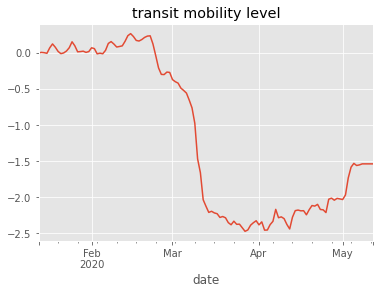

Measures conventions are set according to
https://www.bsg.ox.ac.uk/sites/default/files/2020-05/BSG-WP-2020-032-v5.0_0.pdf, Page 13


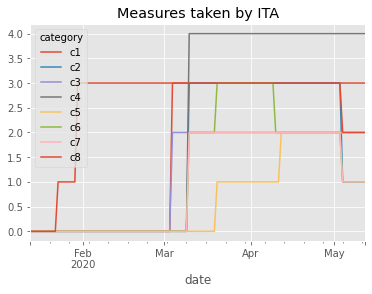

Coefficients: 
 [-0.18806415 -0.36760579 -0.06654378  0.11099761  0.         -0.28478632
  0.         -0.0260066 ]
Mean squared error: 0.08
Coefficient of determination: 0.93


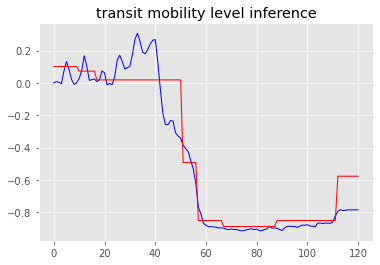

(Lasso(alpha=0.015, copy_X=True, fit_intercept=True, max_iter=1000,
       normalize=False, positive=False, precompute=False, random_state=None,
       selection='cyclic', tol=0.0001, warm_start=False),
 [])

In [6]:
#First test on a country which implemented drastic measures, lockdown : Italy

test_country = 'ITA'

# Choose wether to use your own list or all countries
selected_countries =['FRA', 'ESP', 'DEU', 'GBR', 'DNK']

mobility_category = 'transit'#'grocery_and_pharmacy'
run_linear_regression(mobility_category, test_country, selected_countries)

Countries used for learning,  ['FRA', 'ESP', 'DNK', 'GBR', 'ITA']


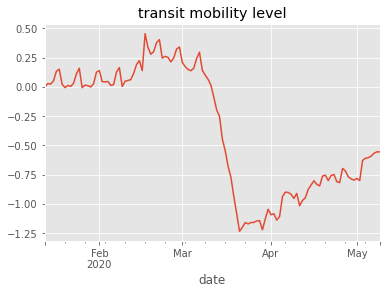

Measures conventions are set according to
https://www.bsg.ox.ac.uk/sites/default/files/2020-05/BSG-WP-2020-032-v5.0_0.pdf, Page 13


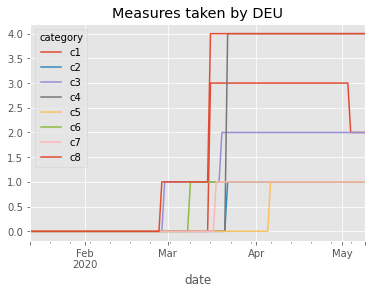

Coefficients: 
 [-0.18950276 -0.17830461 -0.11171608  0.07267537 -0.         -0.46747501
  0.         -0.01892294]
Mean squared error: 0.07
Coefficient of determination: 0.77


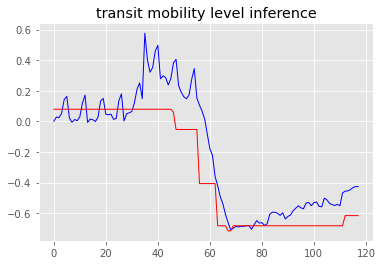

(Lasso(alpha=0.015, copy_X=True, fit_intercept=True, max_iter=1000,
       normalize=False, positive=False, precompute=False, random_state=None,
       selection='cyclic', tol=0.0001, warm_start=False),
 [])

In [7]:
#First test on a country which did not implement drastic measures, no lockdown : Denmark

test_country = 'DEU'

# Choose wether to use your own list or all countries
selected_countries =['FRA', 'ESP', 'DNK', 'GBR','ITA']

mobility_category = 'transit'#'grocery_and_pharmacy'
run_linear_regression(mobility_category, test_country, selected_countries)

### Mobility analysis
- Let's cluster the different countries by typology of mobility

In [ ]:
import numpy as np
from tqdm import tqdm
from dtaidistance import dtw

all_countries = list(set(mobility.reset_index().iso_code) )
mob_train = {}
errors = []
for country in all_countries : 
    try:
        _, mob = build_dataset(country, mobility, oxford_long)
        mob_train[country]=mob
    except KeyError: 
        errors.append(country)
print(mob_train.keys())

mob_train_selection = []
mobility_category = 'transit'
for my_country in mob_train.keys():
    if (mob_train[my_country][mobility_category].std()>0 and
        mob_train[my_country][mobility_category].isnull().sum()<mob_train[my_country].shape[0]*0.2):
        mob_train_selection.append(my_country)

n=len(mob_train_selection)
similarity_matrix = np.empty([n,n])
for i,first_country in tqdm(enumerate(mob_train_selection)):
    for j,second_country in enumerate(mob_train_selection):
        if j>=i:
            first_mob = mob_train[first_country][mobility_category].interpolate(method='nearest').fillna(method='ffill').fillna(method='backfill')
            second_mob = mob_train[second_country][mobility_category].interpolate(method='nearest').fillna(method='ffill').fillna(method='backfill')
            distance = dtw.distance(first_mob,second_mob)
            similarity_matrix[i][j],similarity_matrix[j][i] = distance, distance
        


0it [00:00, ?it/s]

dict_keys(['AUT', 'BFA', 'NGA', 'PHL', 'TWN', 'TZA', 'UGA', 'RWA', 'MAR', 'YEM', 'CZE', 'ARE', 'LBN', 'NOR', 'SRB', 'AUS', 'QAT', 'PRY', 'BEL', 'KOR', 'MDA', 'LAO', 'PER', 'DOM', 'AGO', 'CHE', 'HUN', 'GTM', 'GRC', 'SLV', 'AFG', 'BGD', 'SWE', 'ITA', 'HKG', 'OMN', 'IND', 'CPV', 'USA', 'GAB', 'FIN', 'LKA', 'THA', 'IRL', 'PNG', 'MNG', 'VNM', 'CMR', 'BIH', 'BRB', 'SVN', 'DEU', 'ARG', 'MLI', 'CIV', 'ZMB', 'VEN', 'GUM', 'ISL', 'UKR', 'CRI', 'MMR', 'CHL', 'SVK', 'PRI', 'TTO', 'KEN', 'IRQ', 'MUS', 'GBR', 'NZL', 'JOR', 'ZAF', 'LBY', 'KAZ', 'JPN', 'NER', 'NAM', 'CAN', 'PAN', 'ECU', 'GHA', 'ABW', 'DNK', 'ISR', 'BLZ', 'BRA', 'FRA', 'PAK', 'URY', 'KWT', 'POL', 'KGZ', 'BHR', 'RUS', 'LUX', 'JAM', 'TUR', 'EST', 'HND', 'SAU', 'MOZ', 'COL', 'ALB', 'NIC', 'SGP', 'HRV', 'MEX', 'BWA', 'PRT', 'MYS', 'ROU', 'ZWE', 'BGR', 'BEN', 'BOL', 'ESP', 'EGY', 'NLD', 'IDN', 'GEO'])


15it [02:46,  8.94s/it]

In [ ]:
import seaborn as sns
df_similarity_matrix = pd.DataFrame(similarity_matrix, columns=mob_train_selection, index=mob_train_selection)
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(df_similarity_matrix)

#### Similarity Analysis
> We see some interesting strong similarities between countries. Like Italy and France that have been hit hard by Covid-19 and enforced a total lockdown. But how can we visualize these typologies better?

In [ ]:
sns.clustermap(df_similarity_matrix)

#### Cluster Analysis
> With this new point of view, we are able to detect countries that have indeed taken similar measures leading to similar mobility. For instance this approach shows that Japan and Sweden have similar mobility's profiles. They have both avoided strong lockdown. On the other hand Italy, France and Great Britain belong to the same cluster of drastic mobility loss. Finally we can also detect countries that have decided to handle the crisis with intermediate measures, like Denmark, Germany or Norway.Therefore it seems that this clusterization validates the use of mobility as a convenient proxy for measures.

In [ ]:
from sklearn import manifold

mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(df_similarity_matrix)

In [ ]:
adist = df_similarity_matrix.to_numpy()
amax = np.amax(adist)
adist /= amax

mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(adist)

coords = results.embedding_

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
for label, x, y in zip(df_similarity_matrix.columns, coords[:, 0], coords[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

## Bayesian regression

## Parameterization
We use the following parameterizations:
- (concentration, rate) for the $\mathrm{GammaPoisson}$ distribution.
- (mean, std) for the $\mathrm{Gamma}$ distribution
- (mean, sample size) for the $\mathrm{Beta}$ distribution

In [ ]:
# %load reparameterizations.py

def reparametrize_beta(mean, sample_size):
#     v = numpyro.sample(f'sample_size_{i}', dist.Gamma(*reparametrize_gamma(10., 5)))
    alpha = mean * sample_size
    beta = (1 - mean) * sample_size
    return alpha, beta 

def reparametrize_gamma(mean, std):
    var = std ** 2
    alpha = mean ** 2 / var
    beta = mean / var
    return alpha, beta


Let $M_{t, i} \geq 0$ be here the relative change in mobility, expressed here differently to ease modelling.  
In this section, we thus have $M_{t_i} = 1$ when there is _no change_ in mobility, and $M_{t, i} = 0$ when a 100% diminution has occured (theoretic).

For a mobility category $i$, time $t$, we model $M_{t, i} = \mathbb{E}[m_{t, i}]$ with:

$$M_{t, i} \sim \mathcal{N}(m_{t, i}, \sigma)$$
where the prior for $\sigma$ is $\sigma \sim \mathrm{Exponential}(1) $.

We model:

$$m_{t, i} = \exp(- \sum_k \alpha_{k, i} I_{k, t})$$ 
with 
- $I_{k, t} \in \mathbb{N}$ ordinal indicator of the measure $k$ at time $t$
- $\alpha_{k, i} \geq 0$ to be inferred, with prior $\alpha_{k, i} \sim \mathrm{Gamma}(\frac{1}{N}, 1) - \frac{\log 1.05}{N}$ where $N$ is the number of measures

For simplicity, we do not include the `residential` category, which has opposite correlation with mobility. We also remove the `parks` series, that is quite noisy in some countries.

We fit this model on multiple countries with the same parameters, in order to extract a country-independent effect of measures on mobility.

<!--     - how to handle country-specific behaviors e.g. parks in Sweden, Denmark ? Is it / should it be implemented in the measure indicator ? -->
    
<!-- 
### Approach 2: infer causality ?

- [Article](https://towardsdatascience.com/inferring-causality-in-time-series-data-b8b75fe52c46#99db): _Inferring causality in time series data_
    - [Tigramite](https://github.com/jakobrunge/tigramite): PCMCI - _Causal discovery for time series datasets_
- Paper [Graphical models for time series](https://sci-hub.im/https://ieeexplore.ieee.org/document/5563116): Gaining insight into their computational implementation -->

In [ ]:
import jax.numpy as np

In [ ]:
def sample_parameters(nb_measures, nb_mobilities):
    a = numpyro.sample('a', dist.Normal(0., 0.2))
    alpha = numpyro.sample('alpha', 
                           dist.Gamma(*reparametrize_gamma(1. / nb_measures, 1.)), 
                           sample_shape=(nb_measures, nb_mobilities))
    alpha -= np.log(1.05) / nb_measures
    return a, alpha

In [ ]:
def multi_model(nb_measures, nb_mobilities, all_countries, all_measures, all_mobilities=None):
    a, alpha = sample_parameters(nb_measures, nb_mobilities)
    sigma = numpyro.sample(f'sigma', dist.Exponential(1.), sample_shape=(nb_mobilities,))
    for i in range(len(all_countries)):
        country = all_countries[i]
        measures = all_measures[i]
        mobility = all_mobilities[i] if all_mobilities is not None else None
        
        mu = np.exp(- np.dot(measures, alpha)) + a
        numpyro.sample(f'y_{country}', dist.Normal(mu, sigma), obs=mobility)

In [ ]:
oxford_long.reset_index()['countrycode'].unique()

In [ ]:
def make_all_datasets(mobility, oxford_long, country_names, selected_mobilities):
    all_countries = []
    all_mobilities = []
    all_measures = []
    all_times = []
    for country, subset in oxford_long.groupby('countrycode'):
        if country not in country_names:
            continue
        subset = subset.reset_index('countrycode', drop=True)
        all_countries.append(country)
        subset_measures, subset_mobility = build_dataset(country, mobility, oxford_long)
        
        subset_mobility = subset_mobility[selected_mobilities].add(1).rolling(7, center=True).mean().fillna(method='ffill').fillna(method='bfill')
        all_mobilities.append(np.asarray(subset_mobility))
        all_measures.append(np.asarray(subset_measures))
        all_times.append(subset_mobility.index.to_numpy())
    return all_countries, all_mobilities, all_measures, all_times

SELECTED_COUNTRIES = ['FRA', 'ITA', 'ESP', 'GER', 'SWE', 'GBR', 'DNK']
SELECTED_MOBILITIES = ['transit', 'walking', 'driving', 'grocery_and_pharmacy', 'retail_and_recreation', 'workplaces', 'transit_stations']
all_countries, all_mobilities, all_measures, all_times = make_all_datasets(mobility, oxford_long, SELECTED_COUNTRIES, SELECTED_MOBILITIES)

In [ ]:
for i, country in enumerate(all_countries):
    measures = all_measures[i]
    subset_mobility = all_mobilities[i]
    times = all_times[i]
    pd.DataFrame(subset_mobility, columns=SELECTED_MOBILITIES, index=times).plot()
    plt.title(country)

In [ ]:
nb_measures = all_measures[0].shape[1]
nb_mobilities = all_mobilities[0].shape[1]

mcmc = MCMC(NUTS(multi_model, dense_mass=True), 500, 500, num_chains=1, progress_bar=True)
mcmc.run(PRNGKey(0), 
         nb_measures, nb_mobilities,
         all_countries, all_measures, all_mobilities)
mcmc.print_summary()

In [ ]:
def plot_mobility_results(mu, pi, y_true, times):
    plt.plot(times, y_true, "bx", label="true")
    plt.plot(times, mu, "b--", label="pred")
    plt.fill_between(times, pi[0, :], pi[1, :], color="b", alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.title('Daily deaths')

def plot_y_pred(y_pred, data, times, country):
    mu = np.mean(y_pred, 0)
    pi = np.percentile(y_pred, (10., 90.), 0)
    for i in range(data.shape[1]):
        fig, ax = plt.subplots(figsize=(8, 5))
        plot_mobility_results(mu[:, i], pi[:, :, i], data[:, i], times)
        plt.title(SELECTED_MOBILITIES[i] + ' ' + country)

In [ ]:
predictive = Predictive(multi_model, mcmc.get_samples())
pred = predictive(PRNGKey(0), 
           nb_measures, nb_mobilities, 
           all_countries, all_measures)

for i, country in enumerate(all_countries):
    y_pred = pred[f'y_{country}']
    times = all_times[i]
    subset_mobility = all_mobilities[i]
    plot_y_pred(y_pred, subset_mobility, times, country)

# SEIR-HCD Model

Model built on compartmental models. Each of the following letters represents a compartment of the population of a country:

S - susceptible  
E - exposed  
I - infectious  
R - recovered  
H - hospitalized  
C - critical  
D - deceased  

We normalize these count numbers by the total population of the country.

In [ ]:
%%latex
\begin{align}
\frac{dS}{dt} &= - \frac{R_t}{T_{inf}} I S \\
\frac{dE}{dt} &= \frac{R_t}{T_{inf}} I S - \frac{E}{T_{inc}} \\
\frac{dI}{dt} &= \frac{E}{T_{inc}} - \frac{I}{T_{inf}} \\
\frac{dR}{dt} &= m_a \frac{I}{T_{inf}} + (1 - c_a)\frac{H}{T_{hosp}} \\
\frac{dH}{dt} &= (1 - m_a) \frac{I}{T_{inf}} + (1 - f_a)\frac{C}{T_{crit}} - \frac{H}{T_{hosp}} \\
\frac{dC}{dt} &= c_a \frac{H}{T_{hosp}} - \frac{C}{T_{crit}} \\
\frac{dD}{dt} &= f_a \frac{C}{T_{crit}}
\end{align}

## Parameters used in the model
$R_t$ = reproduction number at time t.  
Typical 3.6* at t=0

Transition times

    T_inc = average incubation period. Typical 5.6* days
    T_inf = average infectious period. Typical 2.9 days
    T_hosp = average time a patient is in hospital before either recovering or becoming critical. Typical 4 days
    T_crit = average time a patient is in a critical state (either recover or die). Typical 14 days

Fractions  
These constants are likely to be age specific (hence the subscript a):

    m_a = fraction of infections that are asymptomatic or mild. Assumed 80% (i.e. 20% severe)
    c_a = fraction of severe cases that turn critical. Assumed 10%
    f_a = fraction of critical cases that are fatal. Assumed 30%
    
*Averages taken from https://www.kaggle.com/covid-19-contributions

### Priors for these parameters
- The Conversation [article](https://theconversation.com/how-long-are-you-infectious-when-you-have-coronavirus-135295):
    - Incubation: 5 days
    - Infectious period: 2 days in incubation, 6 days from symptoms onwards
    - Illness: 10 days
    - NB: _For COVID-19, there is emerging evidence to suggest the infectious period may start 1 to 3 days before you develop symptoms_ 
        - We can reduce incubation time by 2 days and increase infectious time by 2
    - [article](https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30196-1/fulltext)
        - _The peak viral load of patients with MERS-CoV and SARS-CoV infections occurs at around 7–10 days after symptom onset_ 
        - _The median interval between symptom onset and hospitalisation was 4 days (range 0–13)_

- Imperial
    - T_inc: Gamma(5.1, 0.86)
        - _The infection-to-onset distribution is Gamma distributed with mean 5.1 days and coefficient of variation 0.86._   
    - T_inf + T_hosp + T_crit: Gamma(17.8, 0.45)
        - _The onset-to-death distribution is also Gamma distributed with a mean of 17.8 days and a coefficient of variation 0.45._  
    - T_inc + T_inf + T_hosp + T_crit
        - _The infection-to-death distribution is therefore given by: π∼Gamma(5.1,0.86) + Gamma(17.8,0.45)_

## Reproduction number
let $\mathrm{m}_{t, i}$ be the reduction of mobility in the category $i$, relatively to a baseline (before the pandemic).  
Hence $\mathrm{m}_{t, i} > -1$.

We adopt the strong hypothesis that each mobility category presents the same transmission dynamics. Let $R_{t, i}$ be defined by the following linear relationship:
$$ R_{t, i} = (1 + \mathrm{m}_{t, i})R_0 - \mathrm{m}_{t, i}R_1  $$
for any time $t$ through the pandemic, with $R_0$, $R_1$ to be estimated.

We model the effective reproduction number with a weighted mean for each mobility category: 

$$R_t = \sum_i \alpha_i R_{t, i}$$
with $\alpha_i$ to be estimated, where
- $\sum_i \alpha_i = 1$ 
- $\forall i, \alpha_i > 0$

We choose the following prior : $\forall i, \alpha_i \sim \mathrm{Gamma}(1, .5)$

In [ ]:
# %load ode.py
def build_my_odeint(mobility_data, rtol=1e-5, atol=1e-9, mxstep=500):
    """
    code based on jax.experimental.ode.build_ode to make it work with mobility data
    """
    def dz_dt(z, t, r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a, *alpha):
        s = z[0]
        e = z[1]
        i = z[2]
        r = z[3]
        h = z[4]
        c = z[5]
        
        alpha_ = np.array(alpha)
        int_t = np.array([t]).astype(int)[0]
        rt_u = r0 * (1 + mobility_data[int_t]) - r1 * mobility_data[int_t]
        rt = np.dot(rt_u, alpha_)
#         rt = alpha0 * rt_u[0] + alpha1 * rt_u[1]
        
        ds = - (rt / t_inf) * i * s
        de = (rt / t_inf) * i * s - (e / t_inc)
        di = e / t_inc - i / t_inf
        dr = m_a * i / t_inf + (1 - c_a) * (h / t_hosp)
        dh = (1 - m_a) * (i / t_inf) + (1 - f_a) * c / t_crit - h / t_hosp
        dc = c_a * h / t_hosp - c / t_crit
        dd = f_a * c / t_crit

        return np.stack([ds, de, di, dr, dh, dc, dd])

    ct_odeint = jax.custom_transforms(
        lambda y0, t, *args: odeint(dz_dt, y0, t, *args, rtol=rtol, atol=atol, mxstep=mxstep))

    v = lambda y0, t, *args: vjp_odeint(dz_dt, y0, t, *args, rtol=rtol, atol=atol, mxstep=mxstep)

    jax.defvjp_all(ct_odeint, v)

    return jax.jit(ct_odeint)


# Effective reproduction number and death modelling

## Parameterization

### Target
Let $D_t$ be the number of death at time $t$ for a given country. We model $d_t = \mathbb{E}[D_t]$

We sample 
$$D_t \sim \mathrm{GammaPoisson}(\psi, \frac{\psi}{d_t})$$
where $\psi \sim \mathcal{N}^+(0, 5)$

### Compartment initialization
We seed the model with the following, assuming $N$ is the country population:
- $I_0 \sim \mathrm{Gamma}(100, 50) / N$
- $S_0 = 1 - I_0$
- $E_0, R_0, H_0, C_0, D_0 = 0$

### Other priors
$R_0 \sim \mathcal{N}^+(3.28, \kappa_0)$

$R_1 \sim \mathcal{N}^+(0.7, \kappa_1)$

where $\kappa_0, \kappa_1 \sim \mathcal{N}^+(0, .5)$


$T_{inc} \sim \mathrm{Gamma}(5.6, .86)$

$T_{inf} \sim \mathrm{Gamma}(2.9, 1)$

$T_{hosp} \sim \mathrm{Gamma}(4, 1)$

$T_{crit} \sim \mathrm{Gamma}(14, 1)$

$m_a \sim \mathrm{Beta}(0.8, \phi_m)$

$c_a \sim \mathrm{Beta}(0.1, \phi_c)$

$f_a \sim \mathrm{Beta}(0.35, \phi_f)$

where $\phi_m, \phi_c, \phi_f \sim \mathrm{Gamma}(7, 2)$

In [ ]:
# %load prior_means.py
Params = namedtuple('Params', 
                    ['r0', 'r1', 
                     't_inc', 't_inf', 't_hosp', 't_crit', 
                     'm_a', 'c_a', 'f_a']
                   )

# PRIOR_MEANS = Params(
#     r0=3.3,
#     r1=0.5, 
#     t_inc=5.1, 
#     t_inf=2.79, 
#     t_hosp=5.14, 
#     t_crit=5., 
#     m_a=0.85, 
#     c_a=0.2, 
#     f_a=0.33)

PRIOR_MEANS = Params(
    r0=3.28,
    r1=0.2, 
    t_inc=5.6, 
    t_inf=7.9, 
    t_hosp=4., 
    t_crit=14., 
    m_a=0.8, 
    c_a=0.1, 
    f_a=0.35)


In [ ]:
# %load model.py

def make_target_dist(psi_h, psi_c, psi, 
                     daily_hosp, daily_critical, daily_deaths, 
                     bump_hosp, bump_critical, N):
    
    target_dist = dist.GammaPoisson(
                   np.array([psi_h, psi_c, psi]),
                   rate=np.stack([psi_h / (daily_hosp + bump_hosp), 
                                  psi_c / (daily_critical + bump_critical), 
                                  psi / daily_deaths]
                                ).T
    )

    reloc = dist.transforms.AffineTransform(
        loc=np.stack([
            - bump_hosp,
            - bump_critical,
            np.zeros(N)]
        ).T,
        scale=1.)

    reloc_target_dist = dist.TransformedDistribution(target_dist, [reloc])
    return reloc_target_dist

def sample_parameters(nb_mobilities):
    kappa0 = numpyro.sample('kappa0', dist.TruncatedNormal(0, 0., 0.5))
    kappa1 = numpyro.sample('kappa1', dist.TruncatedNormal(0, 0, 0.5))
    r0 = numpyro.sample('r0', dist.TruncatedNormal(0, PRIOR_MEANS.r0, kappa0))
    r1 = numpyro.sample('r1', dist.TruncatedNormal(0, PRIOR_MEANS.r1, kappa1))

    alpha = numpyro.sample('alpha', dist.Gamma(*reparametrize_gamma(1., 0.5)), sample_shape=(nb_mobilities,))
    alpha /= np.sum(alpha)
    
    t_inc = numpyro.sample('t_inc', dist.Gamma(*reparametrize_gamma(PRIOR_MEANS.t_inc, .86)))
    t_inf = numpyro.sample('t_inf', dist.Gamma(*reparametrize_gamma(PRIOR_MEANS.t_inf, 3.)))
    t_hosp = numpyro.sample('t_hosp', dist.Gamma(*reparametrize_gamma(PRIOR_MEANS.t_hosp, 3.)))
    t_crit = numpyro.sample('t_crit', dist.Gamma(*reparametrize_gamma(PRIOR_MEANS.t_crit, 3.)))
    
    sample_size_m = numpyro.sample('sample_size_m', dist.Gamma(*reparametrize_gamma(7., 2)))
    sample_size_c = numpyro.sample('sample_size_c', dist.Gamma(*reparametrize_gamma(7., 2)))
    sample_size_f = numpyro.sample('sample_size_f', dist.Gamma(*reparametrize_gamma(7., 2)))
    m_a = numpyro.sample('m_a', dist.Beta(*reparametrize_beta(PRIOR_MEANS.m_a, sample_size_m)))
#     m_a = 0.8
    c_a = numpyro.sample('c_a', dist.Beta(*reparametrize_beta(PRIOR_MEANS.c_a, sample_size_c)))
    f_a = numpyro.sample('f_a', dist.Beta(*reparametrize_beta(PRIOR_MEANS.f_a, sample_size_f)))
    
    params = (r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)
    
    return params, alpha
    

def sample_compartment_init(pop_country, country_name=None):
#     tau = numpyro.sample('tau', dist.Exponential(0.03))
#     kappa_i0 = numpyro.sample('kappa_i0', dist.TruncatedNormal(0, 0., 0.5))
    i_init = numpyro.sample(f'i_init_{country_name}', 
                            dist.TruncatedNormal(loc=50., scale=10.)
#                             dist.Gamma(*reparametrize_gamma(50, 10.))
#                             dist.Exponential(1. / tau)
                           )
    i_init /= pop_country
    z_init = np.array([1. - i_init, 0., i_init, 0., 0., 0., 0.])
    return z_init
    
def model(seirhcd_int, N, pop_country, y=None, compartments='d', nb_mobilities=1):
    ts = np.arange(float(N))
    params, alpha = sample_parameters(nb_mobilities=nb_mobilities)
    z_init = sample_compartment_init(pop_country)
    
    z = seirhcd_int(z_init, ts, *params, *alpha)
    
    daily_deaths = diff_pop(z[:, -1], pop_country)
    psi = numpyro.sample('psi', dist.TruncatedNormal(scale=5.))

    if compartments == 'd':
        numpyro.sample('deceased', dist.GammaPoisson(psi, rate=psi / daily_deaths), obs=y)

    elif compartments == 'hcd':
        daily_hosp = diff_pop(z[:, -3], pop_country)
        daily_critical = diff_pop(z[:, -2], pop_country)

        hosp = z[:, -3] * pop_country
        critical = z[:, -2] * pop_country

        hosp_m1 = np.hstack(([0.],  hosp[:-1]))
        critical_m1 = np.hstack(([0.],  critical[:-1]))

        bump_hosp = np.min(np.stack([hosp_m1, BUMP_HOSP * np.ones(N)]), axis=0)
        bump_critical = np.min(np.stack([critical_m1, BUMP_CRITICAL * np.ones(N)]), axis=0)

        psi_h = numpyro.sample('psi_h', dist.TruncatedNormal(scale=5.))
        psi_c = numpyro.sample('psi_c', dist.TruncatedNormal(scale=5.))
        
        target_dist = make_target_dist(psi_h, psi_c, psi, 
                                       daily_hosp, daily_critical, daily_deaths, 
                                       bump_hosp, bump_critical, N)
        
        numpyro.sample('y', target_dist, obs=y)

def multi_model(all_countries, all_mobilities, all_populations, observations=None):
    nb_mobilities = all_mobilities[0].shape[1]
    params, alpha = sample_parameters(nb_mobilities=nb_mobilities)
    psi = numpyro.sample('psi', dist.TruncatedNormal(scale=5.))
    i_init = numpyro.sample('i_init', dist.TruncatedNormal(loc=50, scale=10))
    
    for i in range(len(all_countries)):
        country = all_countries[i]
        mobility_data = all_mobilities[i]
        seirhcd_int = build_my_odeint(mobility_data)
        pop_country = all_populations[i]
        if observations is not None:
            y = observations[i]
        else:
            y = None
        
        ts = np.arange(float(mobility_data.shape[0]))

        z_init = np.array([1. - i_init / pop_country, 0., i_init / pop_country, 0., 0., 0., 0.])
        z = seirhcd_int(z_init, ts, *params, *alpha)

        daily_deaths = diff_pop(z[:, -1], pop_country)

        numpyro.sample('deceased_' + country, dist.GammaPoisson(psi, rate=psi / daily_deaths), obs=y)

In [ ]:
# %load postprocess.py

def compute_mu_pi_2(y_pred):
    pop_pred = np.stack([y_pred['hosp'], y_pred['critical'], y_pred['deceased']]).T
    mu = np.mean(pop_pred, 1)
    pi = np.percentile(pop_pred.astype(float), (10., 90.), 1)
    return mu, pi

def compute_mu_pi(y_pred, observation_name='y'):
    pop_pred = y_pred[observation_name]
    mu = np.mean(pop_pred, 0)
    pi = np.percentile(pop_pred.astype(float), (10., 90.), 0)
    return mu, pi

def plot_compartment_results(mu, y_true, times, pi=None):
    plt.plot(times, y_true, "bx", label="true")
    plt.plot(times, mu, "b--", label="pred")
    if pi is not None:
        plt.fill_between(times, pi[0, :], pi[1, :], color="b", alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.title('Daily deaths')

def plot_daily_cumulated(mu, pi, data, times, name):
    fig, ax = plt.subplots(figsize=(8, 5))
    plot_compartment_results(mu, data, times, pi)
    plt.title('Daily ' + name)

    fig, ax = plt.subplots(figsize=(8, 5))
    plot_compartment_results(np.cumsum(mu), np.cumsum(data), times)
    plt.title('Cumulated ' + name)

# # Control for HCD params
def plot_hcd_results(mu, pi, data, times):
    for i, name in enumerate(['deaths', 'critical', 'hospitalized'], start=1):
        plot_daily_cumulated(mu[:, -i], pi[:, :, -i], data[:, -i], times, name)
        
def plot_forest(inference_data):
    az.plot_forest(inference_data, var_names=['t_inc', 't_inf', 't_hosp', 't_crit'], 
                   kind='forestplot', ridgeplot_overlap=3, combined=True, figsize=(9, 3))
    plt.grid()
    az.plot_forest(inference_data, var_names=['m_a', 'c_a', 'f_a'], figsize=(9, 2))
    plt.grid()
    az.plot_forest(inference_data, var_names=['r0', 'r1'], figsize=(9, 2))
    plt.grid()
    az.plot_forest(inference_data, var_names=['alpha'], figsize=(9, 4))
    plt.grid()
    az.plot_forst(inference_data, var_names=['i_init'], figsize=())


## Inference settings

We use a multi-country setting where we train the model on a pool of countries and then predict the number of deceased individuals, as well as $R_t$, on another country.

In order to do this, the model has to learn country-independent parameters, since the only varying factor in countries is the mobility.

In [ ]:
# %load train_test_split.py

def indexslice(l, ix):
    for i, item in enumerate(l):
        if i in ix:
            yield item

def mask_ix(l, mask):
    def aux(l, mask):
        for item, bl in zip(l, mask):
            if bl:
                yield item
    return list(aux(l, mask))

def split_train_test(countries_train, countries_test, all_countries):
    mask_train = [c in countries_train for c in all_countries]
    mask_test = [c in countries_test for c in all_countries]
    return mask_train, mask_test

list(indexslice([1, 2, 3], [0, 2]))
mask_ix([1, 2, 3], [True, False, False]) ;


## Data fetching

In [ ]:
isocodes = fetch_isocodes()
acaps = fetch_acaps(isocodes)
ecdc = fetch_ecdc().set_index(['iso_code', 'date'])
location_code = ecdc.groupby(['location', 'iso_code']).first().iloc[:, 0].reset_index().iloc[:,:2]
apple = fetch_apple(location_code)
google = fetch_google(isocodes, location_code)
mobility = google.join(apple, how='outer')
populations_country = (ecdc.assign(population = lambda f: 
                                   f['new_cases']
                                   .div(f['new_cases_per_million'])
                                   .mul(1_000_000))
                       .groupby('iso_code')
                       ['population']
                       .last())

country_code_lookup = ecdc.reset_index()[['iso_code', 'location']].drop_duplicates().set_index('location').iloc[:, 0]
country_name_lookup = country_code_lookup.reset_index().set_index('iso_code').iloc[:, 0]

In [ ]:
# %load model/preprocessing.py

ix = pd.IndexSlice

mobility_categories = [
        'transit', 'walking', 'driving', 
    'grocery_and_pharmacy', 'retail_and_recreation', 'workplaces', 'transit_stations']

def diff_pop(cumulative, pop_country):
    daily = np.hstack((np.array([0.]), np.diff(cumulative * pop_country)))
    daily += 1
    return daily

def make_dataset(mobility, ecdc, days_before_deaths):
    deaths_subset = ecdc['total_deaths']
    
    ten_deaths_date = deaths_subset.gt(10).idxmax()
    begin_date = ten_deaths_date - pd.Timedelta(days_before_deaths, unit='days')

    total_deaths = deaths_subset.loc[begin_date:].to_numpy()
    times = deaths_subset.loc[begin_date:].index.map(onp.datetime64).to_numpy()

    mobility_subset = mobility[mobility_categories]

    mobility_subset = (mobility_subset
                .reindex(deaths_subset.loc[begin_date:].index)
                .fillna(method='ffill')
                .fillna(method='bfill')
                #.fillna(mobility.iloc[-1])
                .rolling('7d').mean())
    
    mobility_data = np.asarray(mobility_subset.to_numpy())
    return total_deaths, times, mobility_data

def make_all_datasets(mobility, ecdc, populations_country, country_names, days_before_deaths):
    all_countries = []
    all_populations = []
    all_mobilities = []
    all_deaths = []
    all_times = []
    for country, subset in ecdc.groupby('iso_code'):
        if country not in country_names:
            continue
        subset = subset.reset_index('iso_code', drop=True)
        all_countries.append(country)
#         try:
        total_deaths, times, mobility_data = make_dataset(mobility.loc[country], subset, days_before_deaths)
#         except KeyError:
#             continue
        pop_country = populations_country.loc[country]
        daily_deaths = diff_pop(total_deaths / pop_country, pop_country)
        all_populations.append(pop_country)
        all_mobilities.append(mobility_data)
        all_deaths.append(daily_deaths)
        all_times.append(times)
    return all_countries, all_populations, all_mobilities, all_deaths, all_times


In [ ]:
SELECTED_COUNTRIES = [country_code_lookup.loc[name] 
                      for name in 
                      ('Denmark', 'Sweden', 'France', 'Germany', 'United Kingdom', 
                       'Spain', 'Italy'
                      )
                     ]

NB_DAYS_BEFORE_TEN_DEATHS = 30

all_countries, all_populations, all_mobilities, all_deaths, all_times = make_all_datasets(mobility,
                                                                                          ecdc,
                                                                                          populations_country, 
                                                                                          SELECTED_COUNTRIES, 
                                                                                          NB_DAYS_BEFORE_TEN_DEATHS)

In [ ]:
for i, country in enumerate(all_countries):
    pop = all_populations[i]
    mobility_data = all_mobilities[i]
    total_deaths = all_deaths[i]
    times = all_times[i]
    ax = pd.DataFrame(total_deaths).set_index(times).plot(legend=False, figsize=(8, 5))
    pd.DataFrame(mobility_data, columns=mobility_categories).set_index(times).plot(ax=ax, secondary_y=True, legend=False)
    plt.title(country_name_lookup.loc[country])
    plt.legend(loc='lower left')

In [ ]:
mask_train, mask_test = split_train_test([country_code_lookup.loc[name] for name in ['Spain', 'Italy', 'Germany', 'United Kingdom']], 
                                         [country_code_lookup.loc[name] for name in ['Sweden', 'Denmark', 'France']], 
                                         all_countries)
# print(mask_train, mask_test)
print('train countries:', mask_ix(all_countries, mask_train))
print('test countries:', mask_ix(all_countries, mask_test))

## Inference

In [ ]:
mcmc_multi = MCMC(NUTS(multi_model, dense_mass=True), 200, 200, num_chains=NUM_CHAINS)

mcmc_multi.run(PRNGKey(0), 
               all_countries=mask_ix(all_countries, mask_train),
               all_mobilities=mask_ix(all_mobilities, mask_train),
               all_populations=mask_ix(all_populations, mask_train),
              observations=mask_ix(all_deaths, mask_train),
              )

mcmc_multi.print_summary()

## Results

In [ ]:
# %load rt_mobility.py

def reorder(d, mask_train, mask_teset):
    return mask_ix(d, mask_train) + mask_ix(d, mask_test)

def compute_mu_pi_3(data):
    mu = np.mean(data, axis=0)
    pi = np.percentile(data, (10, 90), axis=0)
    return mu, pi

def compute_rt(ts, mobility_data, r0, r1, alpha):    
    rt_u = r0 * (1 + mobility_data[ts]) - r1 * mobility_data[ts]
    rt = np.dot(rt_u, alpha)
    return rt

def compute_rt_samples(samples, mobility_data, N):
    corr_samples = {**samples, **{'alpha': samples['alpha'] / samples['alpha'].sum(axis=1)[:, np.newaxis]}}
    mu, pi = dict(), dict()
    for name in 'r0', 'r1', 'alpha':
        mu[name], pi[name] = compute_mu_pi_3(corr_samples[name])

    ts = np.arange(N)

    rt_pi = onp.empty((corr_samples['r0'].shape[0], times.shape[0]))
    for i in range(corr_samples['r0'].shape[0]):
        rt_pi[i] = compute_rt(ts, mobility_data, 
                              corr_samples['r0'][i], 
                              corr_samples['r1'][i], 
                              corr_samples['alpha'][i])
    
    return rt_pi


In [ ]:
samples = mcmc_multi.get_samples()
predictive = Predictive(multi_model, samples)

y_pred = predictive(PRNGKey(2), 
                    all_countries=reorder(all_countries, mask_train, mask_test),
                    all_mobilities=reorder(all_mobilities, mask_train, mask_test), 
                    all_populations=reorder(all_populations, mask_train, mask_test)
                   )

In [ ]:
for i, country in enumerate(reorder(all_countries, mask_train, mask_test)):
    mu, pi = compute_mu_pi(y_pred, f'deceased_{country}')
    plot_daily_cumulated(mu, pi, reorder(all_deaths, mask_train, mask_test)[i], reorder(all_times, mask_train, mask_test)[i], 
                         f'deaths - {country}')
    mobility_data = reorder(all_mobilities, mask_train, mask_test)[i]
    times = reorder(all_times, mask_train, mask_test)[i]
    rt_pi = compute_rt_samples(samples, mobility_data, times.shape[0])    
    mu, pi = compute_mu_pi_3(rt_pi)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.plot(times, mu)
    plt.xticks(rotation=45)
    plt.fill_between(times, pi[0], pi[1], alpha=0.3, interpolate=True)
    plt.title(f'Rt - {country}')
    
    plt.tight_layout()

In [ ]:
inference_data = az.from_numpyro(mcmc_multi)
plot_forest(inference_data)

### Populations of all compartments over time

In [ ]:
# %load compartments.py

def run_sim_samples(integrator, samples, N, pop_country):
    ts = np.arange(float(N))
    res = []
    for i in range(samples['c_a'].shape[0]):
        post_params = dict()
        for param in 'r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a, alpha'.split(', '):
            post_params[param] = samples[param][i]
    #         post_params[param] = inference_data.posterior[param].values[0, -1]

        i_init = samples['i_init'][i]
        i_init /= pop_country
        z_init = np.array([1. - i_init, 0., i_init, 0., 0., 0., 0.])
        args = list(post_params.values())[:-1]

        alpha = post_params['alpha']
        alpha /= np.sum(alpha)
        
        sim_res = integrator(z_init, ts, *args, *alpha)
        res.append(sim_res)

    res = np.stack(res)
    return res

def plot_compartment(pred_data, true_data, pop_country, times):
    pi = np.percentile(pred_data, (10., 90.), 0)
    
    plt.plot(onp.asarray(times), np.mean(pred_data, axis=0) * pop_country, label='pred')
#     plt.plot(times, true_data, label='true')
    plt.fill_between(onp.asarray(times), pi[0, :] * pop_country, pi[1, :] * pop_country, interpolate=True, alpha=0.3)
    plt.legend()

def plot_hcd(res, pop_country, times, title=None):
    for i, name in enumerate(['hospitalized', 'critical', 'deceased' ], start=5):
        plt.subplots()
#         plot_compartment(res[:, :, -i], hosp_indexed[name].to_numpy(), pop_country)
        plot_compartment(res[:, :, i], np.zeros(res.shape[1]), pop_country, times)
        plt.title(name + ' - ' + title)
    
def plot_seir(res, pop_country, times, title=None):
    for i, name in enumerate(['susceptible', 'exposed', 'infected', 'recovered']):
        plt.subplots()
        plot_compartment(res[:, :, i], np.zeros(res.shape[1]), pop_country, times)
        plt.title(name + ' - ' + title)


In [ ]:
for i, country_code in enumerate(reorder(all_countries, mask_train, mask_test)[:2]):
    all_times_reordered = reorder(all_times, mask_train, mask_test)
    seirhcd_int = build_my_odeint(reorder(all_mobilities, mask_train, mask_test)[i])
    res = run_sim_samples(seirhcd_int, samples, 
                          all_times_reordered[i].shape[0], 
                          reorder(all_populations, mask_train, mask_test)[i])
    plot_seir(res, reorder(all_populations, mask_train, mask_test)[i], all_times_reordered[i], title=country_code)
    plot_hcd(res, reorder(all_populations, mask_train, mask_test)[i], all_times_reordered[i], title=country_code)

#### With synthetic mobility data

todo

# Conclusion
todo  
NB: effectiveness of masks

# Future work

- We could leverage hospitalization and ICU data and feed it to the model, so that it learns based on observations of H, C and D compartments at once. This would reinforce the confidence one can have on the deceased compartment, and $R_t$, predictions, as well as enable the model to estimate other compartments more accurately. An example of dataset that could be used is the one from [IHME](https://covid19.healthdata.org/) that provides estimated numbers.

- We could include [other data sources](https://citymapper.com/cmi/) as additional mobility measurements.


- Combining to make scenarios: one could build a framework that has the following properties:
    - Input : measure, date of implementation, country
    - Output : mobility, $R_t$, deaths [+ infected, hospitalized, critical] time series

Here are some example questions of interest:
- _What if the lockdown had been decided one week later ? Two weeks earlier ?_  
- _What will happen if the lockdown is lifted in one week ? Will we see a spike in hospitals ?_

These questions are of utmost importance for policy makers.

# Sources

- Imperial team
    - [Report 13](https://www.imperial.ac.uk/mrc-global-infectious-disease-analysis/covid-19/report-13-europe-npi-impact/): 30 March 2020
    - [Technical update](https://arxiv.org/abs/2004.11342): 23 april 2020
    - [Code](https://github.com/ImperialCollegeLondon/covid19model) in R and Stan
    - [website](https://mrc-ide.github.io/covid19estimates/#/)


- R0: [An article estimating it](https://academic.oup.com/jtm/article/27/2/taaa021/5735319) 13 Feb 2020


- Compartment models
    - [Wikipedia](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology)
    - SEIR-HCD [Kaggle kernel](https://www.kaggle.com/anjum48/seir-hcd-model) from @anjum (Datasaurus). Sources of inspiration:
        - [Neher labs](https://covid19-scenarios.org/) 
        - [Gabriel Goh](https://gabgoh.github.io/COVID/index.html) 


- Probabilistic programming
    - [numpyro](https://github.com/pyro-ppl/numpyro) ([paper](https://arxiv.org/abs/1912.11554)): probabilistic programming library in python, built on [JAX](https://github.com/google/jax)
    - [SEIR ode modelling](https://docs.pymc.io/notebooks/ODE_API_introduction.html) in Pymc3 
    - [Predator-Prey ode](http://pyro.ai/numpyro/examples/ode.html) in Numpyro 
    - Another [predator-prey](https://fehiepsi.github.io/rethinking-numpyro/16-generalized-linear-madness.html) ode in numpyro
    - [A bayesian SIR](https://github.com/twiecki/covid19) modelling with Pymc3 with the [video](https://youtu.be/C1kWBTj6KvE?t=410)
    - [Estimating COVID-19's $R_t$ in Real-Time with PYMC3](https://github.com/k-sys/covid-19/blob/master/Realtime%20Rt%20mcmc.ipynb)


- Other submissions
    - previous winning solution : [Worldwide measures implementation](https://www.kaggle.com/agneshui/worldwide-measures-implementations)
    - [Covid19 reopening impact with r estimation](https://www.kaggle.com/wjholst/covid-19-reopening-impact-with-r-estimation)


- Misc
    - [generation interval](https://www.medrxiv.org/content/10.1101/2020.03.05.20031815v1)
    - [masks](https://www.preprints.org/manuscript/202004.0203/v1)

*Data sources*

- Epidemiology
    - [Our world in data](https://github.com/owid/covid-19-data/tree/master/public/data): confirmed cases and deaths from ECDC (European center of Disease Control) + tests (collected by owid)


- Mobility
    - [Apple](https://www.apple.com/covid19/mobility) - 3 categories: walking, driving, transit
    - [Google](https://www.google.com/covid19/mobility/) - 6 categories


- Government Measures
<!--     - [ACAPS](https://data.humdata.org/dataset/acaps-covid19-government-measures-dataset) -->
    - [Oxford](https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker)
